In [1]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions
from sklearn.preprocessing import StandardScaler
import pandas as pd
from os import walk
from sklearn.decomposition import PCA
import pickle

%matplotlib inline

In [2]:
model=tf.keras.applications.xception.Xception(weights='imagenet',include_top=True)
#Summary of Xception Model
print(model.summary())

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [3]:
pre_final_model = tf.keras.Model(model.input, model.get_layer("avg_pool").output)

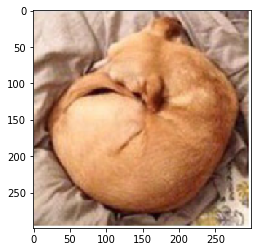

In [4]:
PJES_IMAGE_PATH='./pjes.png'
pjes_img=tf.keras.preprocessing.image.load_img(PJES_IMAGE_PATH,target_size=(299,299))
pjes_img=tf.keras.preprocessing.image.img_to_array(pjes_img)
#view the image
plt.imshow(pjes_img/255.)
pjes_img=tf.keras.applications.xception.preprocess_input(pjes_img)

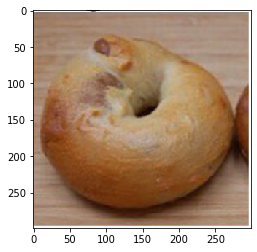

In [5]:
Bulka_IMAGE_PATH='./bulka.png'
bulka_img=tf.keras.preprocessing.image.load_img(Bulka_IMAGE_PATH,target_size=(299,299))
bulka_img=tf.keras.preprocessing.image.img_to_array(bulka_img)
plt.imshow(bulka_img/255.)
bulka_img=tf.keras.applications.xception.preprocess_input(bulka_img)

In [41]:
import requests
#fetching labels from Imagenet  
response=requests.get('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
imgnet_map=response.json()
imgnet_map={v[1]:k for k, v in imgnet_map.items()}

def get_prediction(filename):
    cur_img=tf.keras.preprocessing.image.load_img(filename)
    cur_img=tf.keras.preprocessing.image.img_to_array(cur_img)
    cur_img = tf.keras.preprocessing.image.smart_resize(cur_img, (299, 299), interpolation='bilinear')
    cur_img=tf.keras.applications.xception.preprocess_input(cur_img)
    cur_predictions=model.predict(np.array([cur_img]))
    decoded = decode_predictions(cur_predictions,top=5)
    pre_final_predictions = pre_final_model.predict(np.array([cur_img]))
    return pre_final_predictions, decoded

In [42]:
predictions_pjes=model.predict(np.array([pjes_img]))
decode_predictions(predictions_pjes,top=5)

[[('n07693725', 'bagel', 0.12675144),
  ('n13044778', 'earthstar', 0.09523672),
  ('n07875152', 'potpie', 0.046712946),
  ('n07860988', 'dough', 0.034578137),
  ('n02395406', 'hog', 0.018144205)]]

In [43]:
pre_final_model.predict(np.array([pjes_img]))

array([[0.05384583, 0.        , 0.22001101, ..., 0.        , 0.        ,
        0.13771126]], dtype=float32)

In [44]:
predictions_bulka=model.predict(np.array([bulka_img]))
decode_predictions(predictions_bulka,top=5)

[[('n07693725', 'bagel', 0.9598253),
  ('n07695742', 'pretzel', 0.001848734),
  ('n02776631', 'bakery', 0.0006288528),
  ('n01968897', 'chambered_nautilus', 0.00045748946),
  ('n01945685', 'slug', 0.0003918472)]]

In [45]:
pre_final_model.predict(np.array([bulka_img]))

array([[0.0000000e+00, 7.5958058e-02, 1.5908062e-04, ..., 0.0000000e+00,
        0.0000000e+00, 6.2388605e-01]], dtype=float32)

In [53]:
def generate_plot(path, output_filename):
    results_dict = {"targets": []}
    targets_list = []
    
    #parse model data
    iter = 0
    for _, _, filenames in walk(path):
        for filename in filenames:
            iter += 1
            print("Process:", (iter/len(filenames)) *100)
            pre_final, prediction = get_prediction(path+filename)
            for it, element in enumerate(np.nditer(pre_final.T), start=1):
                if not results_dict.get(f"feature_{it}"):
                    results_dict[f"feature_{it}"] = []
                results_dict[f"feature_{it}"].append(element)
            target = filename.split("-")[0]
            results_dict["targets"].append(target)
            if target not in targets_list:
                targets_list.append(target)
    features = list(results_dict.keys())
    features.remove("targets")
    
    #Create pandas data
    pd_results = pd.DataFrame.from_dict(results_dict)
    x = pd_results.loc[:, features].values
    x = StandardScaler().fit_transform(x)
    
    #Apply PCA
    pca = PCA(n_components=3,whiten=True)
    principalComponents = pca.fit_transform(x)
    print(principalComponents)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
    finalDf = pd.concat([principalDf, pd_results[['targets']]], axis = 1)
    
    #create plot
    ax = plt.axes(projection='3d')
    ax.set_title('3 component PCA', fontsize = 20)
    targets = targets_list
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['targets'] == target
        ax.scatter3D(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , finalDf.loc[indicesToKeep, 'principal component 3']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    plt.savefig(output_filename +'.png')
    finalDf.to_csv(output_filename+".csv", index=False)

    with open("./pca_components", "wb+") as pca_file:
        pickle.dump(pca, pca_file)

Process: 0.012732365673542143
Process: 0.025464731347084286
Process: 0.03819709702062643
Process: 0.05092946269416857
Process: 0.06366182836771073
Process: 0.07639419404125286
Process: 0.08912655971479501
Process: 0.10185892538833714
Process: 0.1145912910618793
Process: 0.12732365673542145
Process: 0.1400560224089636
Process: 0.15278838808250572
Process: 0.16552075375604786
Process: 0.17825311942959002
Process: 0.19098548510313218
Process: 0.2037178507766743
Process: 0.21645021645021645
Process: 0.2291825821237586
Process: 0.24191494779730072
Process: 0.2546473134708429
Process: 0.267379679144385
Process: 0.2801120448179272
Process: 0.2928444104914693
Process: 0.30557677616501144
Process: 0.31830914183855363
Process: 0.3310415075120957
Process: 0.3437738731856379
Process: 0.35650623885918004
Process: 0.36923860453272217
Process: 0.38197097020626436
Process: 0.3947033358798065
Process: 0.4074357015533486
Process: 0.42016806722689076
Process: 0.4329004329004329
Process: 0.445632798573975

Process: 3.7687802393684744
Process: 3.7815126050420167
Process: 3.7942449707155586
Process: 3.806977336389101
Process: 3.819709702062643
Process: 3.832442067736185
Process: 3.8451744334097273
Process: 3.8579067990832696
Process: 3.8706391647568115
Process: 3.8833715304303538
Process: 3.896103896103896
Process: 3.9088362617774384
Process: 3.9215686274509802
Process: 3.9343009931245225
Process: 3.947033358798065
Process: 3.9597657244716067
Process: 3.972498090145149
Process: 3.9852304558186913
Process: 3.997962821492233
Process: 4.010695187165775
Process: 4.023427552839317
Process: 4.03615991851286
Process: 4.048892284186402
Process: 4.061624649859944
Process: 4.0743570155334865
Process: 4.087089381207028
Process: 4.09982174688057
Process: 4.112554112554113
Process: 4.125286478227655
Process: 4.138018843901197
Process: 4.150751209574739
Process: 4.163483575248281
Process: 4.176215940921823
Process: 4.188948306595366
Process: 4.201680672268908
Process: 4.21441303794245
Process: 4.2271454

Process: 7.6266870384517444
Process: 7.639419404125286
Process: 7.652151769798829
Process: 7.66488413547237
Process: 7.677616501145914
Process: 7.690348866819455
Process: 7.703081232492997
Process: 7.715813598166539
Process: 7.728545963840082
Process: 7.741278329513623
Process: 7.754010695187167
Process: 7.7667430608607075
Process: 7.77947542653425
Process: 7.792207792207792
Process: 7.804940157881335
Process: 7.817672523554877
Process: 7.8304048892284195
Process: 7.8431372549019605
Process: 7.855869620575503
Process: 7.868601986249045
Process: 7.881334351922588
Process: 7.89406671759613
Process: 7.906799083269672
Process: 7.919531448943213
Process: 7.932263814616755
Process: 7.944996180290298
Process: 7.95772854596384
Process: 7.970460911637383
Process: 7.9831932773109235
Process: 7.995925642984466
Process: 8.008658008658008
Process: 8.02139037433155
Process: 8.034122740005092
Process: 8.046855105678635
Process: 8.059587471352177
Process: 8.07231983702572
Process: 8.085052202699261
Pr

Process: 11.471861471861471
Process: 11.484593837535014
Process: 11.497326203208557
Process: 11.510058568882098
Process: 11.52279093455564
Process: 11.535523300229181
Process: 11.548255665902724
Process: 11.560988031576267
Process: 11.57372039724981
Process: 11.58645276292335
Process: 11.599185128596893
Process: 11.611917494270434
Process: 11.624649859943977
Process: 11.63738222561752
Process: 11.650114591291063
Process: 11.662846956964604
Process: 11.675579322638146
Process: 11.688311688311687
Process: 11.70104405398523
Process: 11.713776419658773
Process: 11.726508785332316
Process: 11.739241151005857
Process: 11.7519735166794
Process: 11.76470588235294
Process: 11.777438248026485
Process: 11.790170613700026
Process: 11.802902979373568
Process: 11.81563534504711
Process: 11.828367710720652
Process: 11.841100076394193
Process: 11.853832442067738
Process: 11.866564807741279
Process: 11.879297173414821
Process: 11.892029539088362
Process: 11.904761904761903
Process: 11.917494270435448
P

Process: 15.227909345556403
Process: 15.240641711229946
Process: 15.253374076903489
Process: 15.266106442577032
Process: 15.278838808250573
Process: 15.291571173924115
Process: 15.304303539597658
Process: 15.3170359052712
Process: 15.32976827094474
Process: 15.342500636618283
Process: 15.355233002291827
Process: 15.367965367965366
Process: 15.38069773363891
Process: 15.393430099312452
Process: 15.406162464985995
Process: 15.418894830659536
Process: 15.431627196333078
Process: 15.444359562006621
Process: 15.457091927680164
Process: 15.469824293353703
Process: 15.482556659027246
Process: 15.49528902470079
Process: 15.508021390374333
Process: 15.520753756047872
Process: 15.533486121721415
Process: 15.546218487394958
Process: 15.5589508530685
Process: 15.571683218742042
Process: 15.584415584415584
Process: 15.597147950089127
Process: 15.60988031576267
Process: 15.622612681436209
Process: 15.635345047109753
Process: 15.648077412783296
Process: 15.660809778456839
Process: 15.673542144130378


Process: 19.00942195059842
Process: 19.022154316271962
Process: 19.03488668194551
Process: 19.047619047619047
Process: 19.06035141329259
Process: 19.073083778966133
Process: 19.085816144639676
Process: 19.098548510313215
Process: 19.111280875986758
Process: 19.1240132416603
Process: 19.136745607333843
Process: 19.149477973007382
Process: 19.162210338680925
Process: 19.17494270435447
Process: 19.187675070028014
Process: 19.200407435701553
Process: 19.213139801375096
Process: 19.22587216704864
Process: 19.23860453272218
Process: 19.25133689839572
Process: 19.264069264069263
Process: 19.276801629742806
Process: 19.28953399541635
Process: 19.302266361089888
Process: 19.314998726763434
Process: 19.327731092436977
Process: 19.340463458110516
Process: 19.35319582378406
Process: 19.365928189457602
Process: 19.378660555131145
Process: 19.391392920804684
Process: 19.404125286478227
Process: 19.41685765215177
Process: 19.429590017825312
Process: 19.44232238349885
Process: 19.455054749172398
Proce

Process: 22.790934555640437
Process: 22.80366692131398
Process: 22.816399286987522
Process: 22.829131652661065
Process: 22.841864018334608
Process: 22.85459638400815
Process: 22.86732874968169
Process: 22.880061115355232
Process: 22.892793481028775
Process: 22.905525846702318
Process: 22.918258212375857
Process: 22.9309905780494
Process: 22.943722943722943
Process: 22.956455309396485
Process: 22.969187675070028
Process: 22.98192004074357
Process: 22.994652406417114
Process: 23.007384772090656
Process: 23.020117137764196
Process: 23.03284950343774
Process: 23.04558186911128
Process: 23.058314234784824
Process: 23.071046600458363
Process: 23.083778966131906
Process: 23.09651133180545
Process: 23.10924369747899
Process: 23.121976063152534
Process: 23.134708428826077
Process: 23.14744079449962
Process: 23.160173160173162
Process: 23.1729055258467
Process: 23.185637891520244
Process: 23.198370257193787
Process: 23.21110262286733
Process: 23.22383498854087
Process: 23.23656735421441
Process:

Process: 26.572447160682454
Process: 26.585179526355994
Process: 26.59791189202954
Process: 26.610644257703083
Process: 26.623376623376622
Process: 26.636108989050168
Process: 26.648841354723707
Process: 26.661573720397254
Process: 26.674306086070793
Process: 26.687038451744332
Process: 26.69977081741788
Process: 26.712503183091417
Process: 26.725235548764957
Process: 26.737967914438503
Process: 26.750700280112046
Process: 26.763432645785585
Process: 26.77616501145913
Process: 26.78889737713267
Process: 26.801629742806217
Process: 26.814362108479756
Process: 26.827094474153295
Process: 26.83982683982684
Process: 26.85255920550038
Process: 26.86529157117392
Process: 26.878023936847466
Process: 26.89075630252101
Process: 26.90348866819455
Process: 26.916221033868094
Process: 26.928953399541633
Process: 26.94168576521518
Process: 26.95441813088872
Process: 26.967150496562258
Process: 26.979882862235804
Process: 26.992615227909344
Process: 27.00534759358289
Process: 27.01807995925643
Proce

Process: 30.35395976572447
Process: 30.366692131398015
Process: 30.379424497071554
Process: 30.392156862745097
Process: 30.40488922841864
Process: 30.417621594092182
Process: 30.43035395976573
Process: 30.443086325439268
Process: 30.455818691112807
Process: 30.468551056786353
Process: 30.481283422459892
Process: 30.49401578813343
Process: 30.506748153806978
Process: 30.519480519480517
Process: 30.532212885154063
Process: 30.544945250827602
Process: 30.557677616501145
Process: 30.57040998217469
Process: 30.58314234784823
Process: 30.59587471352177
Process: 30.608607079195316
Process: 30.621339444868855
Process: 30.6340718105424
Process: 30.64680417621594
Process: 30.65953654188948
Process: 30.672268907563026
Process: 30.685001273236566
Process: 30.69773363891011
Process: 30.710466004583655
Process: 30.723198370257194
Process: 30.735930735930733
Process: 30.74866310160428
Process: 30.76139546727782
Process: 30.774127832951365
Process: 30.786860198624904
Process: 30.799592564298443
Proces

Process: 34.173669467787114
Process: 34.18640183346066
Process: 34.1991341991342
Process: 34.21186656480774
Process: 34.22459893048128
Process: 34.23733129615483
Process: 34.250063661828364
Process: 34.262796027501906
Process: 34.275528393175456
Process: 34.28826075884899
Process: 34.30099312452254
Process: 34.31372549019608
Process: 34.32645785586962
Process: 34.33919022154316
Process: 34.351922587216706
Process: 34.36465495289024
Process: 34.37738731856379
Process: 34.390119684237334
Process: 34.40285204991088
Process: 34.41558441558442
Process: 34.428316781257955
Process: 34.441049146931505
Process: 34.45378151260504
Process: 34.46651387827858
Process: 34.479246243952126
Process: 34.49197860962567
Process: 34.50471097529921
Process: 34.517443340972754
Process: 34.53017570664629
Process: 34.54290807231984
Process: 34.55564043799338
Process: 34.56837280366692
Process: 34.58110516934047
Process: 34.593837535014
Process: 34.60656990068755
Process: 34.61930226636109
Process: 34.632034632

Process: 38.01884390119684
Process: 38.03157626687039
Process: 38.044308632543924
Process: 38.05704099821747
Process: 38.06977336389102
Process: 38.08250572956455
Process: 38.095238095238095
Process: 38.10797046091164
Process: 38.12070282658518
Process: 38.133435192258716
Process: 38.146167557932266
Process: 38.1588999236058
Process: 38.17163228927935
Process: 38.18436465495289
Process: 38.19709702062643
Process: 38.20982938629997
Process: 38.222561751973515
Process: 38.23529411764706
Process: 38.2480264833206
Process: 38.26075884899414
Process: 38.273491214667686
Process: 38.28622358034123
Process: 38.298955946014765
Process: 38.311688311688314
Process: 38.32442067736185
Process: 38.33715304303539
Process: 38.34988540870894
Process: 38.36261777438248
Process: 38.37535014005603
Process: 38.388082505729564
Process: 38.40081487140311
Process: 38.41354723707665
Process: 38.42627960275019
Process: 38.43901196842373
Process: 38.45174433409728
Process: 38.46447669977081
Process: 38.477209065

Process: 41.86401833460657
Process: 41.87675070028011
Process: 41.889483065953655
Process: 41.9022154316272
Process: 41.91494779730074
Process: 41.927680162974276
Process: 41.940412528647826
Process: 41.95314489432136
Process: 41.965877259994905
Process: 41.97860962566845
Process: 41.99134199134199
Process: 42.00407435701553
Process: 42.016806722689076
Process: 42.02953908836262
Process: 42.04227145403616
Process: 42.055003819709704
Process: 42.06773618538324
Process: 42.08046855105679
Process: 42.093200916730325
Process: 42.10593328240387
Process: 42.11866564807741
Process: 42.13139801375095
Process: 42.144130379424496
Process: 42.15686274509804
Process: 42.16959511077158
Process: 42.182327476445124
Process: 42.19505984211867
Process: 42.2077922077922
Process: 42.22052457346575
Process: 42.23325693913929
Process: 42.24598930481284
Process: 42.25872167048637
Process: 42.271454036159916
Process: 42.28418640183346
Process: 42.296918767507
Process: 42.309651133180544
Process: 42.322383498

Process: 45.7091927680163
Process: 45.72192513368984
Process: 45.73465749936338
Process: 45.74738986503692
Process: 45.760122230710465
Process: 45.77285459638401
Process: 45.78558696205755
Process: 45.79831932773109
Process: 45.811051693404636
Process: 45.82378405907818
Process: 45.836516424751714
Process: 45.849248790425264
Process: 45.8619811560988
Process: 45.87471352177235
Process: 45.887445887445885
Process: 45.90017825311943
Process: 45.91291061879297
Process: 45.92564298446651
Process: 45.938375350140056
Process: 45.9511077158136
Process: 45.96384008148714
Process: 45.976572447160684
Process: 45.98930481283423
Process: 46.00203717850776
Process: 46.01476954418131
Process: 46.02750190985485
Process: 46.04023427552839
Process: 46.052966641201934
Process: 46.06569900687548
Process: 46.07843137254902
Process: 46.09116373822256
Process: 46.103896103896105
Process: 46.11662846956965
Process: 46.12936083524319
Process: 46.142093200916726
Process: 46.154825566590276
Process: 46.16755793

Process: 49.554367201426025
Process: 49.56709956709957
Process: 49.57983193277311
Process: 49.59256429844665
Process: 49.60529666412019
Process: 49.61802902979374
Process: 49.630761395467275
Process: 49.643493761140824
Process: 49.65622612681436
Process: 49.6689584924879
Process: 49.681690858161446
Process: 49.69442322383499
Process: 49.70715558950853
Process: 49.719887955182074
Process: 49.73262032085562
Process: 49.74535268652916
Process: 49.7580850522027
Process: 49.77081741787624
Process: 49.78354978354979
Process: 49.79628214922332
Process: 49.809014514896866
Process: 49.82174688057041
Process: 49.83447924624395
Process: 49.847211611917494
Process: 49.85994397759104
Process: 49.87267634326458
Process: 49.88540870893812
Process: 49.898141074611665
Process: 49.9108734402852
Process: 49.92360580595875
Process: 49.936338171632286
Process: 49.949070537305836
Process: 49.96180290297937
Process: 49.974535268652915
Process: 49.98726763432646
Process: 50.0
Process: 50.01273236567354
Proces

Process: 53.39954163483576
Process: 53.4122740005093
Process: 53.425006366182835
Process: 53.43773873185638
Process: 53.45047109752991
Process: 53.46320346320347
Process: 53.475935828877006
Process: 53.48866819455055
Process: 53.50140056022409
Process: 53.51413292589763
Process: 53.52686529157117
Process: 53.53959765724472
Process: 53.55233002291826
Process: 53.5650623885918
Process: 53.57779475426534
Process: 53.59052711993888
Process: 53.60325948561243
Process: 53.61599185128597
Process: 53.62872421695951
Process: 53.641456582633054
Process: 53.65418894830659
Process: 53.66692131398014
Process: 53.67965367965368
Process: 53.692386045327225
Process: 53.70511841100076
Process: 53.717850776674304
Process: 53.73058314234784
Process: 53.7433155080214
Process: 53.75604787369493
Process: 53.768780239368475
Process: 53.78151260504202
Process: 53.79424497071555
Process: 53.8069773363891
Process: 53.819709702062646
Process: 53.83244206773619
Process: 53.845174433409724
Process: 53.857906799083

Process: 57.231983702571945
Process: 57.24471606824548
Process: 57.25744843391902
Process: 57.270180799592566
Process: 57.2829131652661
Process: 57.29564553093965
Process: 57.308377896613194
Process: 57.32111026228674
Process: 57.33384262796027
Process: 57.346574993633816
Process: 57.35930735930735
Process: 57.37203972498091
Process: 57.384772090654444
Process: 57.39750445632799
Process: 57.41023682200152
Process: 57.422969187675065
Process: 57.435701553348615
Process: 57.44843391902216
Process: 57.4611662846957
Process: 57.473898650369236
Process: 57.48663101604278
Process: 57.499363381716314
Process: 57.51209574738987
Process: 57.52482811306341
Process: 57.53756047873695
Process: 57.55029284441049
Process: 57.56302521008403
Process: 57.57575757575758
Process: 57.58848994143112
Process: 57.60122230710466
Process: 57.6139546727782
Process: 57.62668703845174
Process: 57.63941940412529
Process: 57.652151769798834
Process: 57.66488413547237
Process: 57.67761650114591
Process: 57.690348866

Process: 61.07715813598167
Process: 61.089890501655205
Process: 61.10262286732875
Process: 61.11535523300229
Process: 61.128087598675826
Process: 61.14081996434938
Process: 61.15355233002292
Process: 61.16628469569646
Process: 61.17901706137
Process: 61.19174942704354
Process: 61.20448179271709
Process: 61.21721415839063
Process: 61.229946524064175
Process: 61.24267888973771
Process: 61.25541125541125
Process: 61.2681436210848
Process: 61.280875986758346
Process: 61.29360835243188
Process: 61.306340718105425
Process: 61.31907308377896
Process: 61.3318054494525
Process: 61.34453781512605
Process: 61.357270180799595
Process: 61.37000254647313
Process: 61.382734912146674
Process: 61.39546727782022
Process: 61.40819964349377
Process: 61.42093200916731
Process: 61.433664374840845
Process: 61.44639674051439
Process: 61.45912910618792
Process: 61.471861471861466
Process: 61.484593837535016
Process: 61.49732620320856
Process: 61.5100585688821
Process: 61.52279093455564
Process: 61.535523300229

Process: 64.93506493506493
Process: 64.94779730073847
Process: 64.96052966641201
Process: 64.97326203208557
Process: 64.9859943977591
Process: 64.99872676343264
Process: 65.01145912910619
Process: 65.02419149477973
Process: 65.03692386045327
Process: 65.04965622612681
Process: 65.06238859180036
Process: 65.0751209574739
Process: 65.08785332314744
Process: 65.10058568882098
Process: 65.11331805449453
Process: 65.12605042016807
Process: 65.13878278584161
Process: 65.15151515151516
Process: 65.16424751718868
Process: 65.17697988286224
Process: 65.18971224853578
Process: 65.20244461420933
Process: 65.21517697988286
Process: 65.2279093455564
Process: 65.24064171122996
Process: 65.2533740769035
Process: 65.26610644257703
Process: 65.27883880825057
Process: 65.29157117392411
Process: 65.30430353959765
Process: 65.3170359052712
Process: 65.32976827094474
Process: 65.34250063661828
Process: 65.35523300229183
Process: 65.36796536796537
Process: 65.38069773363891
Process: 65.39343009931245
Proces

Process: 68.83116883116884
Process: 68.84390119684237
Process: 68.85663356251591
Process: 68.86936592818945
Process: 68.88209829386301
Process: 68.89483065953654
Process: 68.90756302521008
Process: 68.92029539088362
Process: 68.93302775655717
Process: 68.94576012223071
Process: 68.95849248790425
Process: 68.9712248535778
Process: 68.98395721925134
Process: 68.99668958492488
Process: 69.00942195059842
Process: 69.02215431627197
Process: 69.03488668194551
Process: 69.04761904761905
Process: 69.06035141329258
Process: 69.07308377896612
Process: 69.08581614463968
Process: 69.09854851031322
Process: 69.11128087598676
Process: 69.1240132416603
Process: 69.13674560733384
Process: 69.1494779730074
Process: 69.16221033868094
Process: 69.17494270435446
Process: 69.187675070028
Process: 69.20040743570155
Process: 69.2131398013751
Process: 69.22587216704864
Process: 69.23860453272218
Process: 69.25133689839572
Process: 69.26406926406926
Process: 69.2768016297428
Process: 69.28953399541635
Process:

Process: 72.72727272727273
Process: 72.74000509294626
Process: 72.7527374586198
Process: 72.76546982429335
Process: 72.7782021899669
Process: 72.79093455564045
Process: 72.80366692131398
Process: 72.81639928698752
Process: 72.82913165266106
Process: 72.8418640183346
Process: 72.85459638400815
Process: 72.86732874968169
Process: 72.88006111535523
Process: 72.89279348102878
Process: 72.90552584670232
Process: 72.91825821237586
Process: 72.9309905780494
Process: 72.94372294372295
Process: 72.95645530939649
Process: 72.96918767507002
Process: 72.98192004074357
Process: 72.99465240641712
Process: 73.00738477209066
Process: 73.0201171377642
Process: 73.03284950343773
Process: 73.04558186911127
Process: 73.05831423478483
Process: 73.07104660045837
Process: 73.0837789661319
Process: 73.09651133180544
Process: 73.10924369747899
Process: 73.12197606315254
Process: 73.13470842882607
Process: 73.14744079449962
Process: 73.16017316017316
Process: 73.1729055258467
Process: 73.18563789152024
Process:

Process: 76.62337662337663
Process: 76.63610898905017
Process: 76.6488413547237
Process: 76.66157372039724
Process: 76.67430608607079
Process: 76.68703845174434
Process: 76.69977081741789
Process: 76.71250318309141
Process: 76.72523554876496
Process: 76.7379679144385
Process: 76.75070028011206
Process: 76.76343264578558
Process: 76.77616501145913
Process: 76.78889737713267
Process: 76.80162974280621
Process: 76.81436210847976
Process: 76.8270944741533
Process: 76.83982683982684
Process: 76.85255920550038
Process: 76.86529157117393
Process: 76.87802393684746
Process: 76.89075630252101
Process: 76.90348866819456
Process: 76.9162210338681
Process: 76.92895339954163
Process: 76.94168576521517
Process: 76.95441813088873
Process: 76.96715049656227
Process: 76.9798828622358
Process: 76.99261522790934
Process: 77.00534759358288
Process: 77.01807995925643
Process: 77.03081232492998
Process: 77.04354469060351
Process: 77.05627705627705
Process: 77.0690094219506
Process: 77.08174178762414
Process

Process: 80.51948051948052
Process: 80.53221288515407
Process: 80.54494525082761
Process: 80.55767761650114
Process: 80.57040998217468
Process: 80.58314234784824
Process: 80.59587471352178
Process: 80.60860707919531
Process: 80.62133944486885
Process: 80.6340718105424
Process: 80.64680417621594
Process: 80.65953654188948
Process: 80.67226890756302
Process: 80.68500127323657
Process: 80.69773363891011
Process: 80.71046600458365
Process: 80.7231983702572
Process: 80.73593073593074
Process: 80.74866310160428
Process: 80.76139546727782
Process: 80.77412783295136
Process: 80.7868601986249
Process: 80.79959256429845
Process: 80.812324929972
Process: 80.82505729564554
Process: 80.83778966131906
Process: 80.8505220269926
Process: 80.86325439266616
Process: 80.8759867583397
Process: 80.88871912401324
Process: 80.90145148968678
Process: 80.91418385536032
Process: 80.92691622103388
Process: 80.93964858670742
Process: 80.95238095238095
Process: 80.96511331805449
Process: 80.97784568372803
Process:

Process: 84.4155844155844
Process: 84.42831678125796
Process: 84.4410491469315
Process: 84.45378151260505
Process: 84.46651387827858
Process: 84.47924624395212
Process: 84.49197860962568
Process: 84.50471097529922
Process: 84.51744334097275
Process: 84.53017570664629
Process: 84.54290807231983
Process: 84.55564043799339
Process: 84.56837280366692
Process: 84.58110516934046
Process: 84.593837535014
Process: 84.60656990068755
Process: 84.61930226636109
Process: 84.63203463203463
Process: 84.64476699770817
Process: 84.65749936338172
Process: 84.67023172905526
Process: 84.6829640947288
Process: 84.69569646040235
Process: 84.70842882607589
Process: 84.72116119174943
Process: 84.73389355742297
Process: 84.7466259230965
Process: 84.75935828877004
Process: 84.7720906544436
Process: 84.78482302011714
Process: 84.79755538579067
Process: 84.81028775146422
Process: 84.82302011713776
Process: 84.83575248281132
Process: 84.84848484848484
Process: 84.86121721415839
Process: 84.87394957983193
Process:

Process: 88.31168831168831
Process: 88.32442067736186
Process: 88.3371530430354
Process: 88.34988540870894
Process: 88.36261777438249
Process: 88.37535014005601
Process: 88.38808250572956
Process: 88.40081487140311
Process: 88.41354723707666
Process: 88.42627960275018
Process: 88.43901196842373
Process: 88.45174433409727
Process: 88.46447669977083
Process: 88.47720906544436
Process: 88.4899414311179
Process: 88.50267379679144
Process: 88.51540616246498
Process: 88.52813852813853
Process: 88.54087089381207
Process: 88.55360325948561
Process: 88.56633562515916
Process: 88.5790679908327
Process: 88.59180035650624
Process: 88.60453272217978
Process: 88.61726508785333
Process: 88.62999745352687
Process: 88.64272981920041
Process: 88.65546218487394
Process: 88.6681945505475
Process: 88.68092691622104
Process: 88.69365928189458
Process: 88.70639164756811
Process: 88.71912401324165
Process: 88.7318563789152
Process: 88.74458874458875
Process: 88.75732111026228
Process: 88.77005347593582
Proces

Process: 92.20779220779221
Process: 92.22052457346575
Process: 92.2332569391393
Process: 92.24598930481284
Process: 92.25872167048638
Process: 92.27145403615992
Process: 92.28418640183345
Process: 92.29691876750701
Process: 92.30965113318055
Process: 92.3223834988541
Process: 92.33511586452762
Process: 92.34784823020117
Process: 92.36058059587471
Process: 92.37331296154827
Process: 92.3860453272218
Process: 92.39877769289534
Process: 92.41151005856888
Process: 92.42424242424242
Process: 92.43697478991596
Process: 92.44970715558951
Process: 92.46243952126305
Process: 92.4751718869366
Process: 92.48790425261014
Process: 92.50063661828368
Process: 92.51336898395722
Process: 92.52610134963076
Process: 92.5388337153043
Process: 92.55156608097785
Process: 92.56429844665138
Process: 92.57703081232494
Process: 92.58976317799848
Process: 92.60249554367202
Process: 92.61522790934555
Process: 92.62796027501909
Process: 92.64069264069265
Process: 92.65342500636619
Process: 92.66615737203972
Proces

Process: 96.1038961038961
Process: 96.11662846956965
Process: 96.12936083524318
Process: 96.14209320091673
Process: 96.15482556659028
Process: 96.16755793226382
Process: 96.18029029793735
Process: 96.19302266361089
Process: 96.20575502928445
Process: 96.21848739495799
Process: 96.23121976063153
Process: 96.24395212630506
Process: 96.2566844919786
Process: 96.26941685765216
Process: 96.2821492233257
Process: 96.29488158899923
Process: 96.30761395467277
Process: 96.32034632034632
Process: 96.33307868601986
Process: 96.3458110516934
Process: 96.35854341736695
Process: 96.37127578304049
Process: 96.38400814871403
Process: 96.39674051438757
Process: 96.40947288006112
Process: 96.42220524573466
Process: 96.4349376114082
Process: 96.44766997708174
Process: 96.46040234275529
Process: 96.47313470842883
Process: 96.48586707410237
Process: 96.49859943977592
Process: 96.51133180544946
Process: 96.52406417112299
Process: 96.53679653679653
Process: 96.54952890247009
Process: 96.56226126814363
Proces

Process: 100.0
[[ 1.52750155 -0.69324264 -0.97544143]
 [-0.81787289 -1.32119405 -0.65967958]
 [ 0.39108302 -0.77024386 -0.02964346]
 ...
 [ 0.7273104  -1.9053813  -0.72558706]
 [ 0.72948389 -1.68008338 -0.79209253]
 [-0.43711774  0.64394118  0.36737762]]


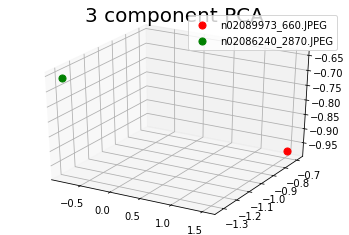

In [54]:
generate_plot("/Users/mtreter/Downloads/imagent-simpl/", "mini-image-net-test")